In [2]:
#w_ji connections
#i is the current neuron
#j is the other neuron

In [3]:
import random
import math
from tqdm import tqdm_notebook
import itertools
from GeneticAlgorithm import *
from ctrnn import *
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.style.use("dark_background")

In [4]:
def getRandomWeight():
    return random.uniform(-15, 15)

def getRandomBias():
    return random.uniform(-15, 15)

def getRandomTau():
    return random.uniform(0.1, 1)

def getRandomState():
    return random.uniform(-5, 5)

#make the individual
class NetworkIndividual(AbstractLinkedListIndividual):
    def __init__(self, neuron_count = 5):
        self.genotype = []
        self.encode_network(neuron_count)
        
    def encode_network(self, neuron_count):
        self.neuron_count = neuron_count
        
        #bias
        bias_ls = [getRandomBias() for i in range(self.neuron_count)]
        #tau
        tau_ls = [getRandomTau() for i in range(self.neuron_count)]
        #states
        state_ls = [getRandomState() for i in range(self.neuron_count)]
        #weights
        weight_ls = [getRandomWeight() for i in range(self.neuron_count * self.neuron_count)]
            
        #genotypeItertool = itertools.chain([self.neuron_count], bias_ls, tau_ls, state_ls, weight_ls)
        #self.genotype = list(genotypeItertool)
        self.genotype = [self.neuron_count]
        self.genotype.extend(bias_ls)
        self.genotype.extend(tau_ls)
        self.genotype.extend(state_ls)
        self.genotype.extend(weight_ls)
        
    def mutate(self, mutation_rate):
        
        bias_offset = 1
        tau_offset = bias_offset + self.neuron_count
        state_offset = tau_offset + self.neuron_count
        weight_offset = state_offset + self.neuron_count
        
        #Skip over the neuron_count in genome
        #TODO: Change this to use the new mutation that is less like random search
        for i in range(bias_offset, len(self.genotype)):
            if random.random() < mutation_rate:
                if i >= weight_offset:
                    self.genotype[i] = getRandomWeight()
                elif i >= state_offset:
                    self.genotype[i] = getRandomState()
                elif i >= tau_offset:
                    self.genotype[i] = getRandomTau()
                elif i >= bias_offset:
                    self.genotype[i] = getRandomBias()

In [5]:
#make the individual
class OscillatingNetworkIndividual(NetworkIndividual):
    def __init__(self, neuron_count = 3):
        self.genotype = []
        self.encode_network(neuron_count)
    
    def fitness(self):
        n = FullyConnectedCTRNN.create_network(self.genotype)
        
        abs_slope_totals = [0.0 for i in range(len(n.neurons))]
        last_output = []
        
        step_size = 0.1
        step_count = 15
        outputs = [n.euler_step(None, step_size) for i in range(step_count)]
        
        for i in range(1, len(outputs)):
            #Sum of total changes in slopes
            for j in range(len(n.neurons)):
                slope = outputs[i-1][j] - outputs[i][j]
                abs_slope_totals[j] += abs(slope)
        
        #Use slope totals to determine if neuron should be oscillating
        output = 0.0
        #A neuron that has a total slope of 500% of the x distance traversed is considered oscillating, partial credit is received
        for abs_slope_total in abs_slope_totals:
            output += min(abs_slope_total / (2 * step_count * step_size), 1.0) #Max is 1.0
            #print("fitness a:", fitness)
        output /= len(n.neurons) #Make each neuron only worth part of the fitness
        #print("fitness b:", fitness)
        return output #normalizze fitness out of [0, 1.0]

In [6]:
#A helping funciton for graphing highest performing individual of a population
def graph_highest_fitness(pop, gen_count):
    test_network = FullyConnectedCTRNN.create_network(pop.fittest_individual.genotype)
    print("weights: [")
    for neuron in test_network.neurons:
        print("\t", neuron.weights)
    print("]")
    print("taus:", [neuron.tau for neuron in test_network.neurons])
    print("bias:", [neuron.bias for neuron in test_network.neurons])
    
    x = []
    y = []
    
    time_step = 0.1
    step_count = 15
    for i in range(step_count):
        x.append(time_step * i)
        y.append(test_network.euler_step(None, time_step))

    #Plot output of each neuron
    plt.title("Output of neurons")
    plt.plot(x, y, '-')
    plt.ylim(0.0, 1.1)
    plt.ylabel("output")
    plt.xlabel("time step")
    plt.show()
    
    #Highest performing over time plot
    #plt.title("Best performing per generation")
    #for point in pop.best_performing_per_generation:
    plt.title("Best performing per generation")
    plt.plot(*zip(*pop.best_performing_per_generation), '.', markersize=12)
    plt.xlim(0, gen_count)
    plt.ylim(0, 1.1)
    plt.ylabel("fitness")
    plt.xlabel("generation")
    plt.show()
    
    print("\n\n\n\n\n")

In [7]:
# %%prun -s cumulative -q -l 10 -T prun4

#Generates 20 seperate populations, and runs reproduction 3000 times on each
population_size = 100
gen_count = 3000

population_count = 20
populations = [TournamentPopulation(OscillatingNetworkIndividual, population_size) for i in range(population_count)]
for i in tqdm_notebook(range(len(populations))):
    pop = populations[i]
    for gen in range(gen_count):
        pop.run_cycle(gen=gen)

Top 5 performing
weights: [
	 [-0.20894021895976245, -0.2635853847900673, 3.1049064748528767]
	 [-6.573416137364573, -14.716774123628381, 6.229217000752449]
	 [-10.023991816535503, 14.968875008874448, 0.21878738512651807]
]
taus: [0.13374961714267344, 0.11661008397726845, 0.22215199656405576]
bias: [-1.0521686052684345, 10.78356168807305, -3.8155637680667773]


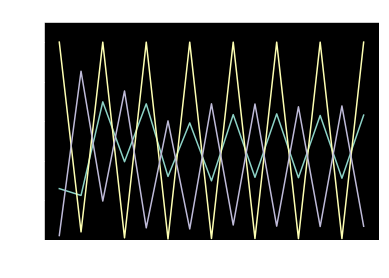

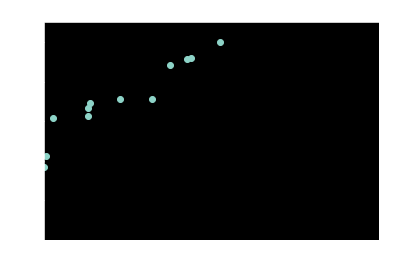







weights: [
	 [0.971474445713751, 4.489431805052902, 1.1850260415744511]
	 [7.240654455901613, -13.47398519936468, 3.1636563245270892]
	 [-11.547230025289666, 10.808114837392793, 6.102500420618249]
]
taus: [0.11150831020086076, 0.1312495470462274, 0.28138855906088117]
bias: [-3.170058083433421, 4.755060406408667, -3.1155760248716007]


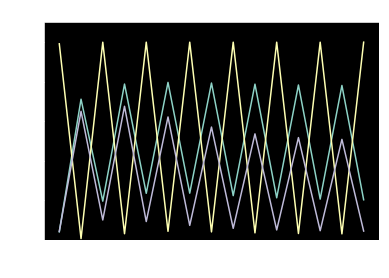

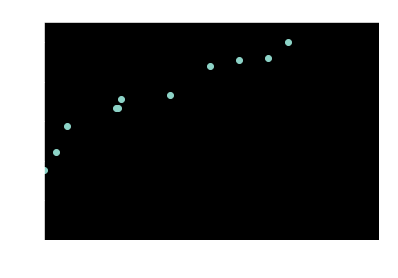







weights: [
	 [-1.1143928354725285, 3.0875318750891125, -2.9307601239077785]
	 [-14.12094269703552, -6.9083795201473315, -14.544433293902024]
	 [-3.600672286667253, -1.4877185829469148, -14.754147650957407]
]
taus: [0.14282900863707687, 0.29287761859714834, 0.14110072200452956]
bias: [2.190470245031978, 14.976279713989857, 12.696831340904165]


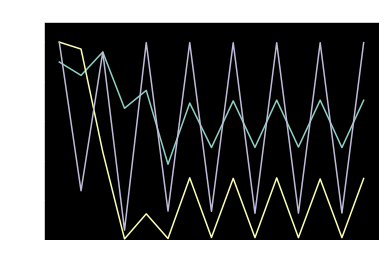

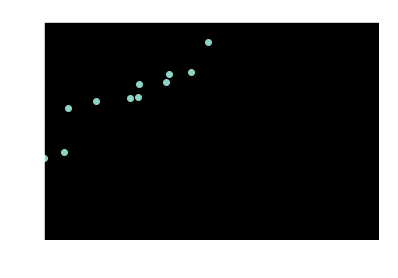







weights: [
	 [3.3082533731968784, 0.6180526222997171, 4.380328163915246]
	 [-8.283769076003033, 5.202438459443947, 14.74102515655374]
	 [11.838584559069322, -2.5553633802706948, -14.819581092987185]
]
taus: [0.1361044503394018, 0.4526679859956878, 0.15765437825798584]
bias: [-4.428976473459253, -6.079743254721613, 3.794598530329292]


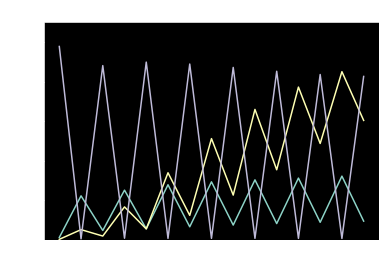

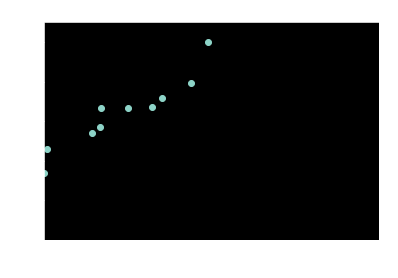







weights: [
	 [3.62880830834383, 2.138112493426161, 4.365695192427076]
	 [-2.5956869062787504, -5.94563162795121, 7.609211187519463]
	 [-0.10222927707832241, 2.117670435677095, -14.8409613424027]
]
taus: [0.1422695728848662, 0.2706411975445888, 0.12816660918655629]
bias: [-5.18690537797773, 2.2672194901233382, 3.3474112554412265]


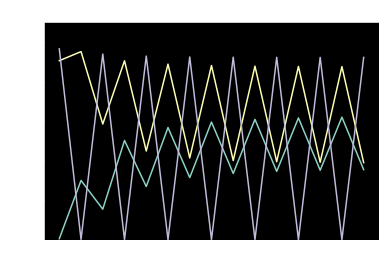

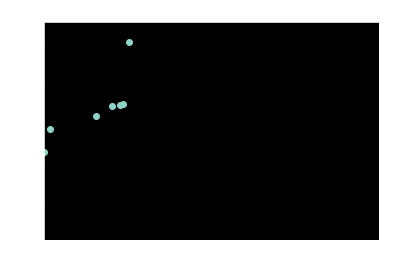

In [8]:
#Sorts and graphs the 5 best performing

print("Top 5 performing")
#Sort populations by fitness
sorted_populations = sorted(populations, key=lambda pop: pop.fittest_individual.fitness() , reverse=True)
#Print top 5 populations? Not sure what to do if multi get perfect points
for pop in sorted_populations[0:5]:
    graph_highest_fitness(pop, gen_count)
    #print(pop.highest_fitness, "==", pop.fittest_individual.fitness())

weights: [
	 [-2.5999878653804376, 4.431944391948457, 2.783907240541744]
	 [9.521437090342722, -12.752002268083835, -4.751781123019157]
	 [6.4733802266971985, 14.56527435604788, -11.5200047548383]
]
taus: [0.14843776991770657, 0.13153161746711767, 0.22684763513635928]
bias: [-1.1131446385859487, 3.2360399492550656, -2.5355839373133975]


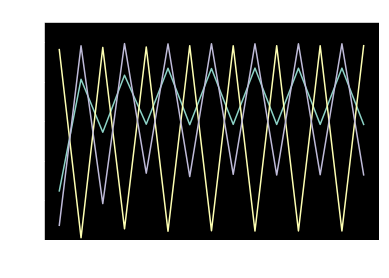

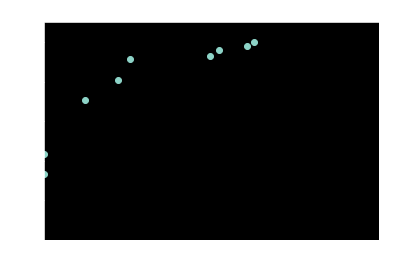

In [10]:
#Prints "worst" performing
worst_pop = sorted_populations[-1]
graph_highest_fitness(worst_pop, gen_count)

In [9]:
print("Runs for", gen_count, "reproductions/mutations aka generations")
print("Base population contains", population_size, "individuals")
print("Initial populations built with weights [-15,15], biases [-15,15], taus [0.1, 1], and states [-5, 5]")
print("Created 20 seperate populations")
print("Fitness is in the range of [0.0, 1.0]")

Runs for 3000 reproductions/mutations aka generations
Base population contains 100 individuals
Initial populations built with weights [-15,15], biases [-15,15], taus [0.1, 1], and states [-5, 5]
Created 20 seperate populations
Fitness is in the range of [0.0, 1.0]
